## Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple
import sys
from pathlib import Path

# Add parent directory to path to import Models
# This works for notebooks in the Experiments folder
project_root = Path.cwd().parent if Path.cwd().name == 'Experiments' else Path.cwd()
sys.path.insert(0, str(project_root))

# Import from Models folder (note: no .py extension needed)
from Models.MC_Dropout import (
    MCDropoutRegressor,
    train_model,
    mc_dropout_predict,
    gaussian_nll,
    beta_nll,
    plot_toy_data,
    plot_uncertainties,
    normalize_x,
    normalize_x_data
)



## Genarte toy data sets

In [3]:
# Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ----- Data generation for linear function with homo/heteroscedastic noise -----
# f(x) = 0.7x + 0.5
# noise_type: 'homoscedastic' (σ(x) = 0.20) or 'heteroscedastic' (σ(x) = 0.10 + 0.2(0.5 + 0.5sin(x)))
def generate_toy_regression(n_train=1000, train_range=(0.0, 10.0), ood_range=(10.0, 15.0), 
                           grid_points=600, ood_points=200, noise_type='heteroscedastic', type = "linear"):
    low, high = train_range
    x_train = np.random.uniform(low, high, size=(n_train, 1))
    
    if type == "linear":
        # Linear function: f(x) = 0.7x + 0.5
        f_clean = lambda x: 0.7 * x + 0.5
        y_clean_train = f_clean(x_train)

    elif type == "non-linear":
        # Polynomial function: f(x) = 0.5 + 0.5x + 0.05x^3
        #7 sin(x) + 3| cos(x/2)| with ∼ N (0, 1)
        f_clean = lambda x: 4 * np.sin(x) + 3 * np.abs(np.cos(x/2))
        y_clean_train = f_clean(x_train)
    else:
        raise ValueError("type must be 'linear', 'non-linear'")

    # Define noise variance σ²(x)
    if noise_type == 'homoscedastic':
        # Homoscedastic: σ(x) = 0.8
        sigma = 0.8
        sigma_train = np.full_like(x_train, sigma)
    elif noise_type == 'heteroscedastic':
        # Heteroscedastic: 
        sigma_train = np.abs(0.5* x_train)
    else:
        raise ValueError("noise_type must be 'homoscedastic' or 'heteroscedastic'")
    
    # Generate noise: ε | x ~ N(0, σ²(x))
    epsilon = np.random.normal(0.0, sigma_train, size=(n_train, 1))
    y_train = y_clean_train + epsilon

    # Dense evaluation grid within training range
    x_grid_train = np.linspace(train_range[0], train_range[1], grid_points).reshape(-1, 1)
    y_grid_clean_train = f_clean(x_grid_train)
    
    # OOD evaluation grid
    x_grid_ood = np.linspace(ood_range[0], ood_range[1], ood_points).reshape(-1, 1)
    y_grid_clean_ood = f_clean(x_grid_ood)
    
    # Combine training and OOD grids
    x_grid = np.vstack([x_grid_train, x_grid_ood])
    y_grid_clean = np.vstack([y_grid_clean_train, y_grid_clean_ood])
    
    # Create mask for OOD region
    ood_mask = np.zeros(len(x_grid), dtype=bool)
    ood_mask[grid_points:] = True  # OOD points start after training points

    return (x_train.astype(np.float32), y_train.astype(np.float32),
            x_grid.astype(np.float32), y_grid_clean.astype(np.float32), ood_mask)

In [4]:
def plot_toy_data(x_train, y_train, x_grid, y_clean, title="Toy Regression Data"):
    """Plot the training data and clean function"""
    plt.figure(figsize=(12, 6))
    
    # Plot training data points
    plt.scatter(x_train, y_train, alpha=0.6, s=20, label="Training data", color='blue')
    
    # Plot clean function
    plt.plot(x_grid, y_clean, 'r--', linewidth=2, label="Clean f(x) = 0.7x + 0.5")
    
    # Add vertical line to separate training and OOD regions
    plt.axvline(x=10, color='black', linestyle=':', alpha=0.7, linewidth=1)
    plt.text(5, plt.ylim()[1]*0.9, "Training (0-10)", ha="center", va="center", fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    plt.text(12.5, plt.ylim()[1]*0.9, "OOD (10-15)", ha="center", va="center", fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [5]:
# Linear function with homoscedastic noise
x_train_homo, y_train_homo, x_grid_homo, y_clean_homo, ood_mask_homo = generate_toy_regression(
    n_train=1000, 
    train_range=(-5, 5), 
    ood_range=(5, 15.0),
    noise_type='homoscedastic',
    type = "non-linear"
)

# Linear function with heteroscedastic noise (default - used in most experiments)
x_train, y_train, x_grid, y_clean, ood_mask = generate_toy_regression(
    n_train=1000, 
    train_range=(-5, 5), 
    ood_range=(5, 15.0),
    noise_type='heteroscedastic',
    type = "non-linear"
)

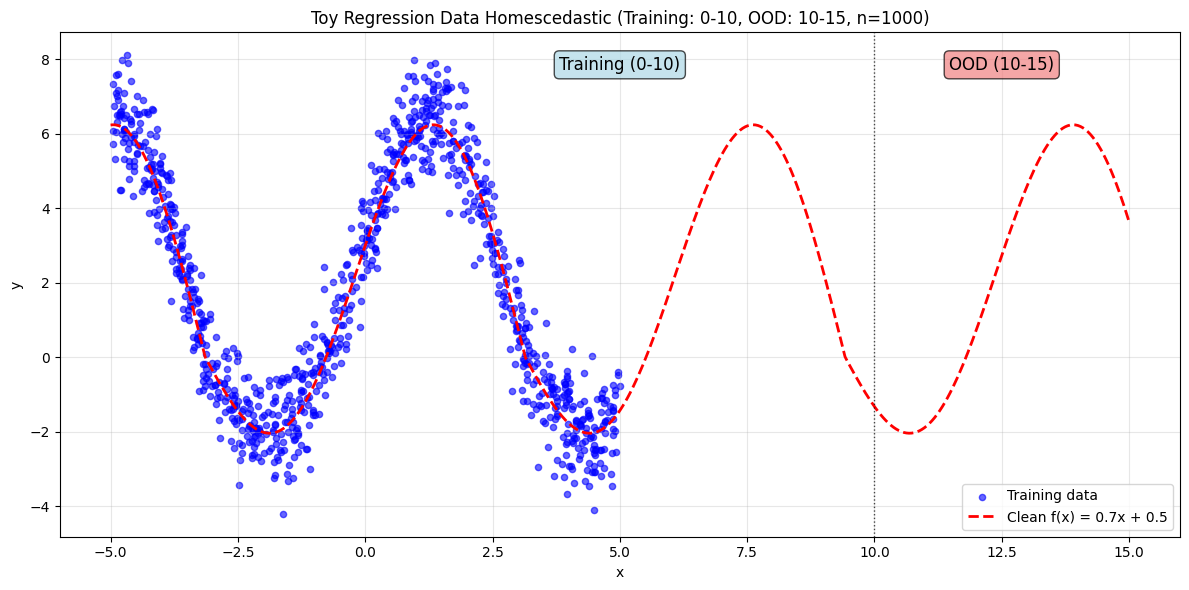

In [6]:
plot_toy_data(x_train_homo, y_train_homo, x_grid_homo, y_clean_homo, title="Toy Regression Data Homescedastic (Training: 0-10, OOD: 10-15, n=1000)")

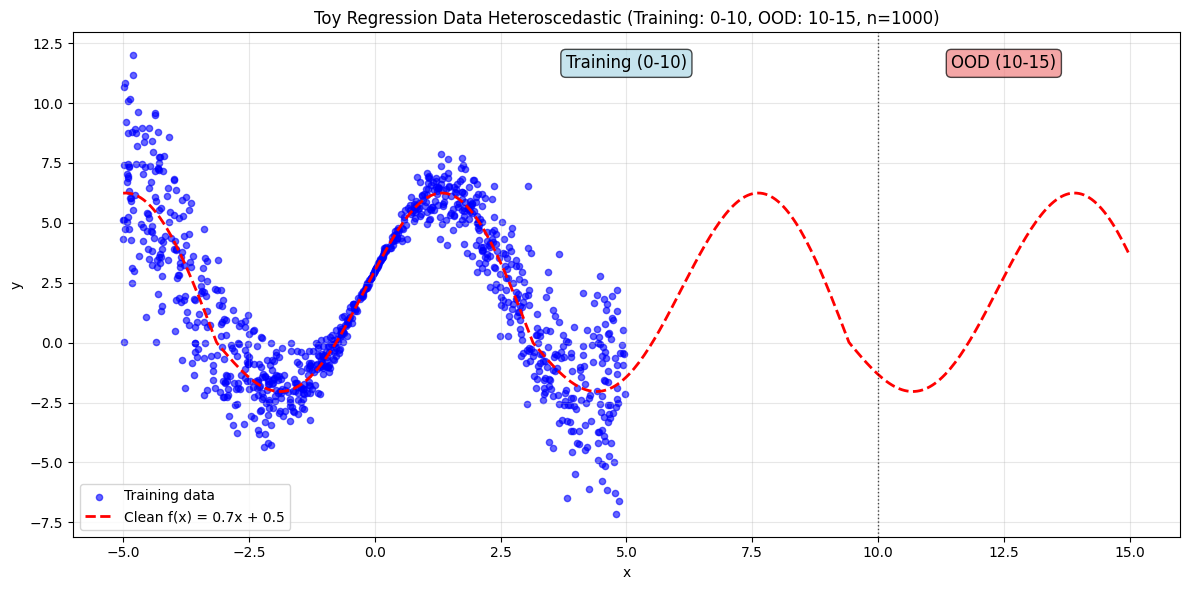

In [7]:
plot_toy_data(x_train, y_train, x_grid, y_clean, title="Toy Regression Data Heteroscedastic (Training: 0-10, OOD: 10-15, n=1000)")

## Function to plot uncertanties

In [ ]:
# Simplified plotting function without OOD
def plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_clean, mu_pred, ale_var, epi_var, tot_var, title):
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    x = x_grid[:, 0]
    
    # Plot 1: Predictive mean + Total uncertainty
    axes[0].scatter(x_train_subset[:, 0], y_train_subset[:, 0], alpha=0.6, s=20, color='blue', label="Training data", zorder=3)
    axes[0].plot(x, mu_pred, 'b-', linewidth=2, label="Predictive mean")
    axes[0].fill_between(x, mu_pred - np.sqrt(tot_var), mu_pred + np.sqrt(tot_var), 
                        alpha=0.3, color='blue', label="±σ(total)")
    axes[0].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = 0.7x + 0.5")
    axes[0].set_ylabel("y")
    axes[0].set_title(f"{title}: Predictive Mean + Total Uncertainty")
    axes[0].legend(loc="upper left")
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Predictive mean + Aleatoric uncertainty only
    axes[1].scatter(x_train_subset[:, 0], y_train_subset[:, 0], alpha=0.6, s=20, color='blue', label="Training data", zorder=3)
    axes[1].plot(x, mu_pred, 'b-', linewidth=2, label="Predictive mean")
    axes[1].fill_between(x, mu_pred - np.sqrt(ale_var), mu_pred + np.sqrt(ale_var), 
                        alpha=0.3, color='green', label="±σ(aleatoric)")
    axes[1].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = 0.7x + 0.5")
    axes[1].set_ylabel("y")
    axes[1].set_title(f"{title}: Predictive Mean + Aleatoric Uncertainty")
    axes[1].legend(loc="upper left")
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Predictive mean + Epistemic uncertainty only
    axes[2].scatter(x_train_subset[:, 0], y_train_subset[:, 0], alpha=0.6, s=20, color='blue', label="Training data", zorder=3)
    axes[2].plot(x, mu_pred, 'b-', linewidth=2, label="Predictive mean")
    axes[2].fill_between(x, mu_pred - np.sqrt(epi_var), mu_pred + np.sqrt(epi_var), 
                        alpha=0.3, color='orange', label="±σ(epistemic)")
    axes[2].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = 0.7x + 0.5")
    axes[2].set_ylabel("y")
    axes[2].set_xlabel("x")
    axes[2].set_title(f"{title}: Predictive Mean + Epistemic Uncertainty")
    axes[2].legend(loc="upper left")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## Sample size Heteroscedastic

In [ ]:
# Loop through different function types: linear, non-linear, sin
function_types = ["linear", "non-linear"]
function_names = {"linear": "Linear", "non-linear": "Non-Linear"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type})")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate full dataset (we'll only use training data, no OOD)
    x_train_full, y_train_full, x_grid_full, y_grid_clean_full, ood_mask_full = generate_toy_regression(
        n_train=1000, 
        train_range=(10, 30), 
        ood_range=(30, 45),
        grid_points=600,
        noise_type='heteroscedastic',
        type=func_type
    )

    # Extract only training range grid (no OOD) - first grid_points elements
    grid_points = 600
    x_grid = x_grid_full[:grid_points]
    y_grid_clean = y_grid_clean_full[:grid_points]

    # Training data percentages to test
    percentages = [1, 5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Normalize input x (y stays in original scale)
        x_mean, x_std = normalize_x(x_train_subset)
        x_train_subset_norm = normalize_x_data(x_train_subset, x_mean, x_std)
        x_grid_norm = normalize_x_data(x_grid, x_mean, x_std)
        
        # Create dataloader with normalized x (y stays in original scale)
        ds = TensorDataset(torch.from_numpy(x_train_subset_norm), torch.from_numpy(y_train_subset))
        loader = DataLoader(ds, batch_size=32, shuffle=True)
        
        # Train MC Dropout model with beta-NLL (β=0.5)
        model = MCDropoutRegressor(p=0.1)
        train_model(model, loader, epochs=700, lr=1e-3, loss_type='beta_nll', beta=0.5)
        
        # Make predictions using normalized x_grid (predictions are in original y scale)
        mu_pred, ale_var, epi_var, tot_var = mc_dropout_predict(model, x_grid_norm, M=20)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
        
        # Plot uncertainties (original absolute units plot)
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"MC Dropout (β-NLL, β=0.5) - {function_names[func_type]} - {pct}% training data")
    

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    


    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
        
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Create line plot of normalized average uncertainties
    plt.figure(figsize=(10, 6))
    plt.plot(percentages, avg_ale_norm_list, 'o-', linewidth=2, markersize=8, label='Aleatoric Uncertainty', color='green')
    plt.plot(percentages, avg_epi_norm_list, 's-', linewidth=2, markersize=8, label='Epistemic Uncertainty', color='orange')
    plt.plot(percentages, avg_tot_norm_list, '^-', linewidth=2, markersize=8, label='Total Uncertainty', color='blue')

    plt.xlabel('Training Data Percentage (%)', fontsize=12)
    plt.ylabel('Normalized Average Uncertainty', fontsize=12)
    plt.title(f'Normalized Average Uncertainties vs Training Data Percentage - {function_names[func_type]} Function (Heteroscedastic)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 105)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()


################################################################################
# Function Type: Linear (linear)
################################################################################



NameError: name 'np' is not defined

## Smaple size Homoscedastic

In [ ]:
# Loop through different function types: linear, non-linear, sin
function_types = ["linear", "non-linear", "sin"]
function_names = {"linear": "Linear", "non-linear": "Polynomial", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type})")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate full dataset (we'll only use training data, no OOD)
    x_train_full, y_train_full, x_grid_full, y_grid_clean_full, ood_mask_full = generate_toy_regression(
        n_train=1000, 
        train_range=(10, 30), 
        ood_range=(30, 45),
        grid_points=600,
        noise_type='homoscedastic',
        type=func_type
    )

    # Extract only training range grid (no OOD) - first grid_points elements
    grid_points = 600
    x_grid = x_grid_full[:grid_points]
    y_grid_clean = y_grid_clean_full[:grid_points]

    # Training data percentages to test
    percentages = [1, 5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Create dataloader
        ds = TensorDataset(torch.from_numpy(x_train_subset), torch.from_numpy(y_train_subset))
        loader = DataLoader(ds, batch_size=32, shuffle=True)
        
        # Train MC Dropout model with beta-NLL (β=0.5)
        model = MCDropoutRegressor(p=0.1)
        train_model(model, loader, epochs=700, lr=1e-3, loss_type='beta_nll', beta=0.5)
        
        # Make predictions
        mu_pred, ale_var, epi_var, tot_var = mc_dropout_predict(model, x_grid, M=20)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
    
        # Plot uncertainties
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"MC Dropout (β-NLL, β=0.5) - {function_names[func_type]} - {pct}% training data")

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    all_tot = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['tot']) for pct in percentages])

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    tot_min, tot_max = all_tot.min(), all_tot.max()

    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
    
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Create line plot of normalized average uncertainties
    plt.figure(figsize=(10, 6))
    plt.plot(percentages, avg_ale_norm_list, 'o-', linewidth=2, markersize=8, label='Aleatoric Uncertainty', color='green')
    plt.plot(percentages, avg_epi_norm_list, 's-', linewidth=2, markersize=8, label='Epistemic Uncertainty', color='orange')
    plt.plot(percentages, avg_tot_norm_list, '^-', linewidth=2, markersize=8, label='Total Uncertainty', color='blue')

    plt.xlabel('Training Data Percentage (%)', fontsize=12)
    plt.ylabel('Normalized Average Uncertainty', fontsize=12)
    plt.title(f'Normalized Average Uncertainties vs Training Data Percentage - {function_names[func_type]} Function (Homoscedastic)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 105)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

### Esemble

In [ ]:


# ----- Run end-to-end -----
def main():
    # Data - using consistent ranges: training 0-10, OOD 10-15, 1000 samples
    x_train, y_train, x_grid, y_clean, ood_mask = generate_toy_regression(
        n_train=1000,
        train_range=(0.0, 10.0),
        ood_range=(10.0, 15.0),
        noise_type='heteroscedastic'
    )

    # Train ensemble with NLL
    ens_nll = train_ensemble(x_train, y_train, batch_size=32, K=5, loss_type='nll', beta=0.5)
    mu_nll, ale_nll, epi_nll, tot_nll = ensemble_predict(ens_nll, x_grid)
    plot_uncertainties(x_grid, y_clean, mu_nll, ale_nll, epi_nll, tot_nll, ood_mask, title="Ensembles (NLL)")

    # Train ensemble with β-NLL (β=0.5)
    ens_bnll = train_ensemble(x_train, y_train, batch_size=32, K=5, loss_type='beta_nll', beta=0.5)
    mu_bnll, ale_bnll, epi_bnll, tot_bnll = ensemble_predict(ens_bnll, x_grid)
    plot_uncertainties(x_grid, y_clean, mu_bnll, ale_bnll, epi_bnll, tot_bnll, ood_mask, title="Ensembles (β-NLL, β=0.5)")

if __name__ == "__main__":
    main()


